## Import Modules

In this section, we need the following modules:

In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Part 1: Importing the DICOM file

We do this using `read_file` function. As you can see the shape of the image is (512, 512).

In [2]:
img = pydicom.read_file('file1.dcm')
img.pixel_array.shape

(512, 512)

### Part 2: Image data

We can use DICOM attributes to get this data:

`Bits Allocated`: The number of bits used to actually contain each sample of each pixel.  
`Bits Stored`: The number of bits actually used by each sample of each pixel.  
‍‍‍‍`Modality`: The imaging method used  
`BodyPartExamined`: The part of body in the image.  


In [3]:
print('Bits allocated:', img.BitsAllocated)
print('Bits stored:', img.BitsStored)
print('Imaging method:', img.Modality)
print('Part of the body:', img.BodyPartExamined)

Bits allocated: 16
Bits stored: 12
Imaging method: CT
Part of the body: CHEST


### Part 3: Downsampling seperately

We can access the image matrix using `img.pixel_array` and downsample it using python slicing:

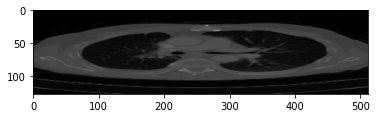

In [4]:
# down sample the x by 4
img_downsampled_x = img.pixel_array[::4, :]
plt.imshow(img_downsampled_x, cmap='gray');

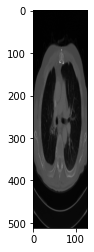

In [5]:
# down sample the y by 4
img_downsampled_y = img.pixel_array[:, ::4]
plt.imshow(img_downsampled_y, cmap='gray');

### Part 4: Downsampling in both x and y directions

In this part we downsample the image simultaneously in both directions x and y by 2.

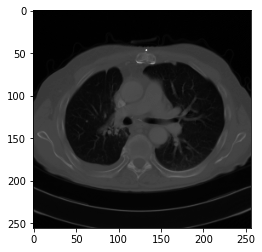

In [6]:
# down sample the x by 4
img_downsampled_x = img.pixel_array[::2, ::2]
plt.imshow(img_downsampled_x, cmap='gray');

### Part 5: Comparing the downsampled images

1. If we consider the number of lost pixels after downsampling, all images have the same number of lost pixels and the number of pixels are divided by 4. So, from this point of view there is no difference between these 3 images.  
  
2. Another think to consider is losing details in a specific direction. In the first image (downsampled toward x) we have pixel loss in horizontal direction where as in the second image (downsampled toward y) the dirction of loss is vertical. So, if you look at horizontal details in the image, you see them distorted in the first image but more clear in the second image. The third image is better with respect to this evaluation metric because the scaling factor of directions are the same. As a result, the amount of distortion is balanced across the two directions and the result is more similar to the original image.

### Part 6: Nearest Neighbor, Bilinear Interpolation and Bicubic Interpolation

We can use `cv2.resize` function to perform resampling operation. We set the scaling factor in both direction to 2 because we downsampled the image by 2.

In [7]:
img_nn = cv2.resize(img_downsampled_x, (0,0), fx=2, fy=2, interpolation=cv2.INTER_NEAREST)
img_bilinear = cv2.resize(img_downsampled_x, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
img_bicubic = cv2.resize(img_downsampled_x, (0,0), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

Now we can plot our images:

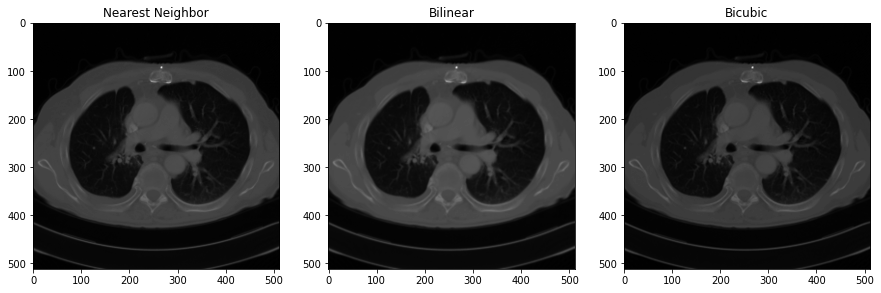

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_nn, cmap='gray')
ax[0].set_title('Nearest Neighbor')
ax[1].imshow(img_bilinear, cmap='gray')
ax[1].set_title('Bilinear')
ax[2].imshow(img_bicubic, cmap='gray')
ax[2].set_title('Bicubic')
plt.show()

we can implement a function to calculate the differences between these images and the original image.  
‌Because the fact that our images dtype is `uint16` we must use `int16` for our resulting matrix to support the whole range of possible outputs after subtracting. 

In [9]:
def difference(img1, img2):
    dif = np.subtract(img1, img2, dtype=np.int16)
    dif = np.abs(dif)
    return dif / np.max(dif)

Now we can plot the differences:

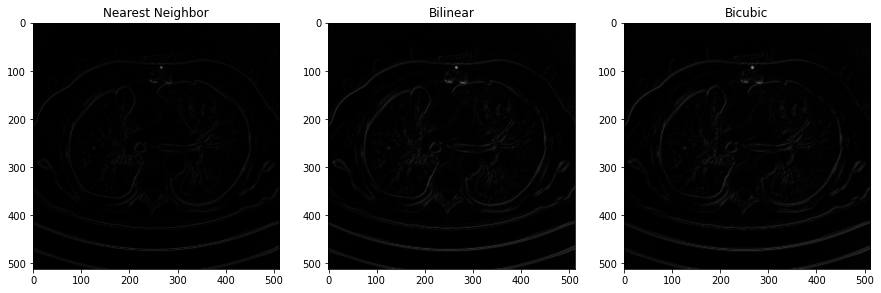

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

nn_difference = difference(img_nn, img.pixel_array)
bilinear_difference = difference(img_bilinear, img.pixel_array)
bicubic_difference = difference(img_bicubic, img.pixel_array)

ax[0].imshow(nn_difference, cmap='gray')
ax[0].set_title('Nearest Neighbor')
ax[1].imshow(bilinear_difference, cmap='gray')
ax[1].set_title('Bilinear')
ax[2].imshow(bicubic_difference, cmap='gray')
ax[2].set_title('Bicubic')
plt.show()

As you can see the nearest neighbor method has performed better because the difference image is darker and the differences is less than other images.  
It is good to calculate the sum and the variance of each difference matrix.

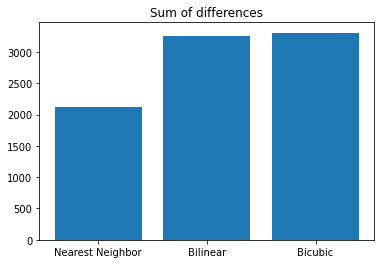

In [16]:
# calculating the sums
plt.bar(['Nearest Neighbor', 'Bilinear', 'Bicubic'], [np.sum(nn_difference), np.sum(bilinear_difference), np.sum(bicubic_difference)])
plt.title('Sum of differences')
plt.show()

As it is demonstrated in plot, nearest neighbor method has less error than other methods. Moreover, bilinear method has performed a little bit better than the bicubic method.
Now, we can plot the variances:

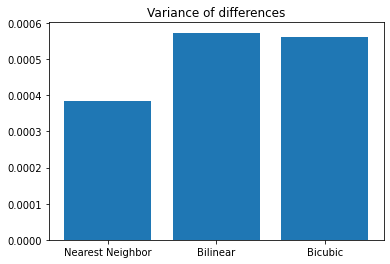

In [17]:
# calculating the variances
plt.bar(['Nearest Neighbor', 'Bilinear', 'Bicubic'], [np.var(nn_difference), np.var(bilinear_difference), np.var(bicubic_difference)])
plt.title('Variance of differences')
plt.show()

As same as before, nearest neighbor method has lower variance than others. however, with respect to this evaluation metric, the bicubic method has better performance than bilinear method.

### Part 7: Saving the image

To save the image as bitmap file, we convert it to `uint8` and use `cv2.imwrite` function.  
To save the image as .tif file, we convert it to `uint16`.  

In [22]:
# save the original image as .bmp file
bmp_img = img.pixel_array.astype(np.uint8)
cv2.imwrite('original.bmp', bmp_img)

# save the original image as .tif file
tif_img = img.pixel_array.astype(np.uint16)
cv2.imwrite('original.tif', tif_img);

The resulting images are saved as `original.bmp` and `original.tif` in the same directory as this notebook.